# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Импортируем все необдходимое

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def describe(X: pd.DataFrame, y: pd. Series):
    X_copy = X.copy()
    X_copy["is_ultra"] = y
    return X_copy.describe()


RANDOM_SEED = 42

##  Откроем и изучим файл

In [2]:
frame = pd.read_csv('datasets/users_behavior.csv')

<div class="alert alert-info">
<b>Вот касаемо нейминга - датафреймы лучше именовать df, тоже общепринятая вещь. примеры во всех бибилотеках именуют так</b> 

In [3]:
frame.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


### Проверим типы данных

In [4]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


#### Результаты проверки 
Изменим тип поля messages на int, потому что дробных сообщений быть не может

In [5]:
frame['messages']=frame['messages'].astype("int")

<div class="alert alert-warning">
<b>А звонки (calls) может быть тоже поменять? их тоже дробных не бывает</b> 
</div>


### Проверим  дубликаты

In [6]:
frame.duplicated().sum()

0

<div class="alert alert-info">
<b>хорошая практика делать такую проверку</b>
</div>

#### Результаты проверки 
Дубликатов не найдено

### Проверка на корректность наименований столбцов

In [7]:
frame.columns

Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

#### Результаты проверки 
Имена столбцов заданы корректно

### Проверим значения содержащиеся в столбцах

In [8]:
frame.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


<div class="alert alert-info">
<b>как по мне - очень удобно смотреть именно транспонированное значение дескрайба, может пригодиться:</b>
</div>

In [6]:
frame.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


### Вывод

1. Пропущенных значений нет
1. Типы столбцов в порядке
1. Дубликатов нет
2. Датафрейм не сбалансирован. Позже, надо будет произвести балансировку обучающей выборки с помощью imbalanced-learn

<div class="alert alert-warning">
<b>целевой признак не сбалансирован, все таки не датафрейм</b> 
</div>

# Разобьем данные на выборки

Разделим данные на целевой столбец и матрицу признаков

In [8]:
X = frame.copy()
X = X.drop(columns=["is_ultra"])
y = frame["is_ultra"]

<div class="alert alert-warning">
<b> мне кажется вот так было бы правильнее, если ты все таки делаешь копию, чтобы избежать мутаций:</b>  

X = frame.drop(columns=["is_ultra"]).copy()

y = frame["is_ultra"].copy()

вообще в пандас предпочтительно использовать цепочки методов, вот хорошая статья:


[4 анти-паттерна pandas и способы борьбы с ними](https://habr.com/ru/companies/wunderfund/articles/682388/)

</div>

Так как у нас нет скрытой тестовой выборки - сделаем свою

In [9]:
(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(X,
                            y,
                            test_size = 0.33,
                            random_state = RANDOM_SEED
                                       )


Проведем балансировку

In [15]:
# На случай, если балансировка не применяется
X_balanced = X_train
y_balanced = y_train

<div class="alert alert-warning">
<b> а вот тут было бы круто оставить признаки без балансировки, чтобы посмотреть как это влияет на качество модели:</b>  
то есть обучать модель как на X_train, y_train, так и на X_balanced, y_balanced - это будут две совершенно разные обученные модели.
</div>

<div class="alert alert-warning">
<b> не забывай про мультиколлинеарность, избавление от мультиколлинеарных признаков может сильно повысить качество модели:</b>  
</div>

In [11]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


<Axes: >

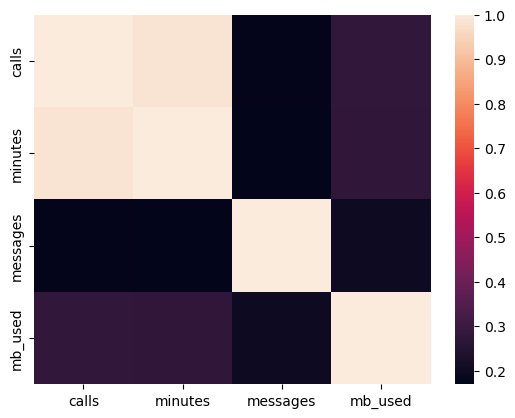

In [16]:
import seaborn as sns

sns.heatmap(X_balanced.corr())

<div class="alert alert-info">
<b> смотри, звонки и минуты сильно скореллированы. можно попробовать стратегии: </b>

1. удалить или один, или другой. чтобы понять какой удалить можно либо в тупую попробовать, либо воспользоваться расчетом VIF, либо каким нибудь PCA.

2. объединить признаки - это называется feature engineering. то есть по сути придумать формулу, объединяющую эти два признака в один


полезные статьи по теме:

https://stats.stackexchange.com/questions/361020/why-is-multicollinearity-so-bad-for-machine-learning-models-and-what-can-we-do-a
https://habr.com/ru/companies/akbarsdigital/articles/592493/
https://medium.com/analytics-vidhya/removing-multi-collinearity-for-linear-and-logistic-regression-f1fa744f3666
https://towardsdatascience.com/how-to-remove-multicollinearity-in-dataset-using-pca-4b4561c28d0b
https://machinelearningmastery.com/information-gain-and-mutual-information/


</div>

In [17]:
over = RandomOverSampler(sampling_strategy=1)
X_balanced, y_balanced = over.fit_resample(X_train, y_train)
# under = RandomUnderSampler(sampling_strategy=0.7)
# X, y = under.fit_resample(X, y)

c:\Users\IgorMitrofanov\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\IgorMitrofanov\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\IgorMitrofanov\anaconda3\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\IgorMitrofanov\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(

<div class="alert alert-info">
<b> прикольно. когда я делал работу пару лет назад, насколько я помню таких штук еще не было. приходилось оверсамплить в ручную) </b>
</div>

Проведем иследование сформированной выборки

In [67]:
describe(X_balanced, y_balanced)

,calls,minutes,messages,mb_used,is_ultra
count,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000
mean,66.097204,459.955496,42.131824,17739.559790,0.500000
std,36.696756,259.014059,41.329769,8228.154397,0.500083
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,278.750000,8.000000,12323.802500,0.000000
50%,65.000000,445.030000,31.000000,17286.235000,0.500000
75%,87.000000,612.192500,63.000000,22345.097500,1.000000
max,203.000000,1566.450000,224.000000,49745.730000,1.000000


Сравним с обучающей выборкой

In [68]:
describe(X_train, y_train)

,calls,minutes,messages,mb_used,is_ultra
count,2153.000000,2153.000000,2153.000000,2153.000000,2153.000000
mean,63.569438,441.917255,38.439387,17088.302411,0.302369
std,33.207525,234.717055,36.468135,7426.242514,0.459391
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,279.060000,9.000000,12388.400000,0.000000
50%,63.000000,432.750000,30.000000,16835.990000,0.000000
75%,83.000000,578.570000,57.000000,21289.280000,1.000000
max,203.000000,1566.450000,224.000000,49745.730000,1.000000


Теперь разделим тестовую выборку на тестовую и валидационную

In [19]:
(X_valid,
 X_test,
 y_valid,
 y_test) = train_test_split(X_test,
                            y_test,
                            test_size = 0.5,
                            random_state = RANDOM_SEED
                                       )

<div class="alert alert-info">
давай я ради эксперимента создам новые фичи, где удалю `calls`

In [20]:
X_balanced_mod = X_balanced.drop('calls', axis=1)
X_valid_mod = X_valid.drop('calls', axis=1)
X_test_mod = X_test.drop('calls', axis=1)

#  Исследуем модели

## Random Forest

Поиск лучшего классификатора по точности предсказания и по матрице ошибок

<div class="alert alert-info">
в ML постоянно могут мешать надоедливые warnings, это можно отключить так:

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
best_RF = None
best_accuracy_RF = 0
best_est_RF = 0
best_depth_RF = 0
exit = False
est = 5
TARGET = (0, 0) # Ищем то, что приведет к меньшему числу ложных рекомендаций Смарт. Этот параметр в матрице должен быть минимальных среди моделей
min_target = len(X_valid)
parameters = []
for est in tqdm(range(1,33)):
    for depth in range(2, 10):
        RF = RandomForestClassifier(random_state = RANDOM_SEED,n_estimators = est, max_depth = depth)
        RF.fit(X_balanced, y_balanced)
        prediction_valid_RF = RF.predict(X_valid)
        cm = confusion_matrix(prediction_valid_RF, y_valid)
        accuracy_RF = accuracy_score(prediction_valid_RF, y_valid)
        if cm[TARGET[0]][TARGET[1]] < min_target:
            min_target = cm[TARGET[0]][TARGET[1]]
            best_RF_on_cm = RF
            best_accuracy_RF_on_cm = accuracy_RF
        
        parameters.append((est, depth, accuracy_RF))
        if best_accuracy_RF < accuracy_RF:
            best_RF = RF
            best_depth_RF = depth
            best_est_RF = est
            best_accuracy_RF = accuracy_RF
print(best_RF, best_RF_on_cm)
            

100%|██████████| 32/32 [00:10<00:00,  3.03it/s]

RandomForestClassifier(max_depth=9, n_estimators=31, random_state=42) RandomForestClassifier(max_depth=4, n_estimators=1, random_state=42)


<div class="alert alert-info">
ниже показываю пример как сделать поиск по сетке с 5-кратной кросс-валидацией. это значит что валидационная выборка выбирается случайно 5 раз в трейн данных:

In [34]:
# для этого мне не понадобится заранее выделенная валидационная выборка:
X_balanced_mod_wo_valid = pd.concat([X_balanced_mod, X_valid_mod])
y_balanced_mod_wo_valid = pd.concat([y_balanced, y_valid])

In [35]:
from sklearn.model_selection import GridSearchCV

best_result = {
    'model': None,
    'accuracy': 0,
    'estimators': 0,
    'depth': 0,
}

param_grid = {
    'n_estimators': range(1, 33),
    'max_depth': range(2, 10),
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=RANDOM_SEED), param_grid, cv=5, verbose=True)
grid_search.fit(X_balanced_mod_wo_valid, y_balanced_mod_wo_valid)

for params, mean_score, _ in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['std_test_score']):
    print(f"Parameters: {params}, Mean accuracy: {mean_score}, Std: {_.round(4)}")

best_result['model'] = grid_search.best_estimator_
best_result['accuracy'] = grid_search.best_score_
best_result['estimators'] = grid_search.best_params_['n_estimators']
best_result['depth'] = grid_search.best_params_['max_depth']

print("Best Model:", best_result['model'])
print("Best Accuracy:", best_result['accuracy'])
print("Best Parameters:", best_result['estimators'], "estimators,", best_result['depth'], "depth")


Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Parameters: {'max_depth': 2, 'n_estimators': 1}, Mean accuracy: 0.6573219644910667, Std: 0.0172
Parameters: {'max_depth': 2, 'n_estimators': 2}, Mean accuracy: 0.7150490241253991, Std: 0.0119
Parameters: {'max_depth': 2, 'n_estimators': 3}, Mean accuracy: 0.7198608812722631, Std: 0.0123
Parameters: {'max_depth': 2, 'n_estimators': 4}, Mean accuracy: 0.7071294341089309, Std: 0.018
Parameters: {'max_depth': 2, 'n_estimators': 5}, Mean accuracy: 0.6958064037889018, Std: 0.0159
Parameters: {'max_depth': 2, 'n_estimators': 6}, Mean accuracy: 0.6822238962058893, Std: 0.0175
Parameters: {'max_depth': 2, 'n_estimators': 7}, Mean accuracy: 0.6791177660866047, Std: 0.0044
Parameters: {'max_depth': 2, 'n_estimators': 8}, Mean accuracy: 0.7062795757519904, Std: 0.0139
Parameters: {'max_depth': 2, 'n_estimators': 9}, Mean accuracy: 0.6912806375740771, Std: 0.0155
Parameters: {'max_depth': 2, 'n_estimators': 10}, Mean accuracy: 0.714485

<div class="alert alert-info">
результат на тесте:

In [36]:
prediction_test = best_result['model'].predict(X_test_mod)
accuracy_score(prediction_test, y_test)

0.8097928436911488

Для ускорения повторного обращения к блокноту создадим лес по лучшим параметрам для сбалансированной обучающей выборки (33, 4)
Для несбалансированной выборки лучшая точность достигается при 4, 4


In [51]:
# best_RF = RandomForestClassifier(random_state = RANDOM_SEED,n_estimators = 33, max_depth = 4)
# best_RF.fit(X_balanced, y_balanced)
# prediction_valid_RF = best_RF.predict(X_valid)
# best_accuracy_RF = accuracy_score(prediction_valid_RF, y_valid)

## Decision Tree

In [71]:
best_DT = None
best_accuracy_DT = 0
best_depth_DT = 0
for depth in tqdm(range(2,20)):
    DT = DecisionTreeClassifier(random_state = RANDOM_SEED, max_depth = depth)
    DT.fit(X_balanced, y_balanced)
    prediction_valid_DT = DT.predict(X_valid)
    accuracy_DT = accuracy_score(prediction_valid_DT, y_valid)
    if best_accuracy_DT < accuracy_DT:
        best_DT = DT
        best_accuracy_DT = accuracy_DT
        best_depth_DT = depth

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 27.67it/s]


Лучшая модель Decision tree


## LogisticRegression

In [75]:
LR = LogisticRegression(random_state = RANDOM_SEED,max_iter= 1000,tol=1e-5,solver = 'lbfgs' )
LR.fit(X_train, y_train)
prediction_valid_LR = LR.predict(X_valid)
accuracy_LR = accuracy_score(prediction_valid_LR, y_valid)

In [76]:
print(f"Logistic Regression: {accuracy_LR}")
print(f"Random Forest: {best_accuracy_RF}")
print(f"Random Forest on CM: {best_accuracy_RF_on_cm}")
print(f"Decision Tree: {best_accuracy_DT}")

Logistic Regression: 0.6992481203007519
Random Forest: 0.8270676691729323
Random Forest on CM: 0.7142857142857143
Decision Tree: 0.8045112781954887


## Вывод 

Основываясь на показателе точности, можно  прийти к выводу, что наиболее качественные результаты прогнозирует Random Forest

# Проверьте модель на тестовой выборке

In [77]:
prediction_test_LR = LR.predict(X_test)
prediction_test_RF = best_RF.predict(X_test)
prediction_test_RF_on_cm = best_RF_on_cm.predict(X_test)
prediction_test_DT = best_DT.predict(X_test)

In [87]:
accuracy_LR_test = accuracy_score(prediction_test_LR, y_test)
accuracy_RF_test = accuracy_score(prediction_test_RF, y_test)
accuracy_RF_test_on_cm = accuracy_score(prediction_test_RF_on_cm, y_test)
accuracy_DT_test = accuracy_score(prediction_test_DT, y_test)

In [88]:
print(f"Logistic Regression:\t {accuracy_LR_test}")
print(f"Random Forest:\t {accuracy_RF_test}")
print(f"Random Forest on confusion matrix:\t {accuracy_RF_test_on_cm}")
print(f"Decision Tree:\t {accuracy_DT_test}")

Logistic Regression:	 0.7368421052631579
Random Forest:	 0.7744360902255639
Random Forest on confusion matrix:	 0.7368421052631579
Decision Tree:	 0.7593984962406015


In [80]:
# Чтобы видеть - балансированная выборка или нет - участвовала в обучении
describe(X_balanced, y_balanced)

,calls,minutes,messages,mb_used,is_ultra
count,3004.000000,3004.000000,3004.000000,3004.000000,3004.000000
mean,66.097204,459.955496,42.131824,17739.559790,0.500000
std,36.696756,259.014059,41.329769,8228.154397,0.500083
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,278.750000,8.000000,12323.802500,0.000000
50%,65.000000,445.030000,31.000000,17286.235000,0.500000
75%,87.000000,612.192500,63.000000,22345.097500,1.000000
max,203.000000,1566.450000,224.000000,49745.730000,1.000000


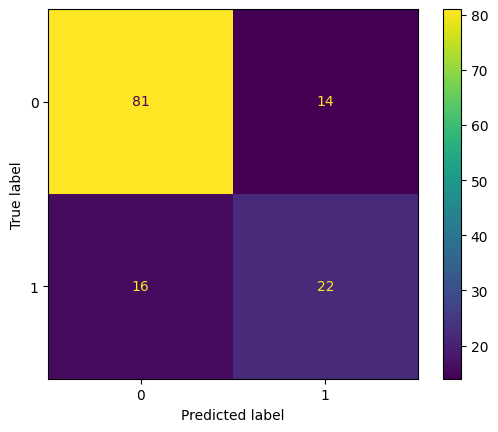

In [81]:
disp = ConfusionMatrixDisplay.from_estimator(best_RF, X_test, y_test)

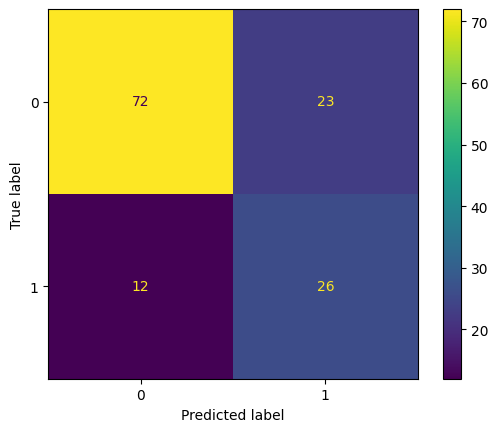

In [82]:
disp = ConfusionMatrixDisplay.from_estimator(best_RF_on_cm, X_test, y_test)

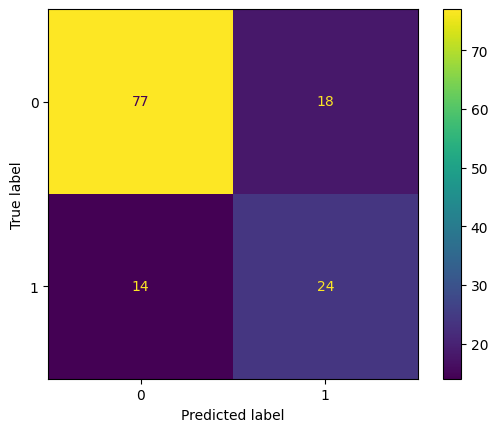

In [83]:
disp = ConfusionMatrixDisplay.from_estimator(best_DT, X_test, y_test)

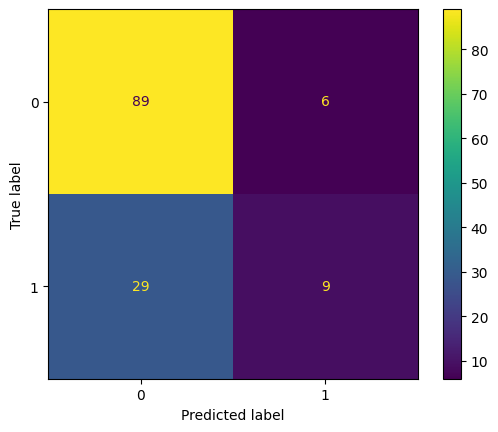

In [84]:
disp = ConfusionMatrixDisplay.from_estimator(LR, X_test, y_test)

## Вывод

Результаты на тестовой выборке

* Logistic Regression:	 0.7368421052631579
* Random Forest:	 0.7744360902255639
* Random Forest on confusion matrix:	 0.7368421052631579
* Decision Tree:	 0.7593984962406015

Лес и дерево показали неплохие результаты. При этом, на валидационной выборке результаты в некоторых итерациях достигали 86% точности. Это говорит о недостаточности данных для обучения модели для более высокой точности, что очевидно и без результатов сравнения.

Валидация успешности модели может осуществляться различными методами. Например, для леса был добавлен критерий - количество ложных рекомендаций трифа Смарт должно быть минимально. Такая модель имеет сниженную точность предсказаний, но в руках маркетологов позволила бы достичь большей прибыли, но это не точно.

*** Конец ознакомительного фрагмента. Для более точного аудита мы готовы произвести для вас более обширное исследование, результаты которого помогут вам извлечь максимум прибыли из вашего бизнеса.

<div class="alert alert-info">

*** Конец ознакомительного фрагмента. Для более точного аудита мы готовы произвести для вас более обширное исследование, результаты которого помогут вам извлечь максимум прибыли из вашего бизнеса.

а это что?))))

рекомедную еще проверить результат на случайной модели, чтобы проверить твои модели на адекватность:

In [37]:
from sklearn.dummy import DummyClassifier

In [53]:
dummy_model = DummyClassifier(random_state=RANDOM_SEED, strategy='most_frequent')
dummy_model.fit(X_balanced, y_balanced)

DummyClassifier(random_state=42, strategy='most_frequent')

In [54]:
dummy_predictions = dummy_model.predict(X_test)

In [55]:
accuracy_score(y_test, dummy_predictions)

0.696798493408663